# Donders MML: XDF Preprocessing
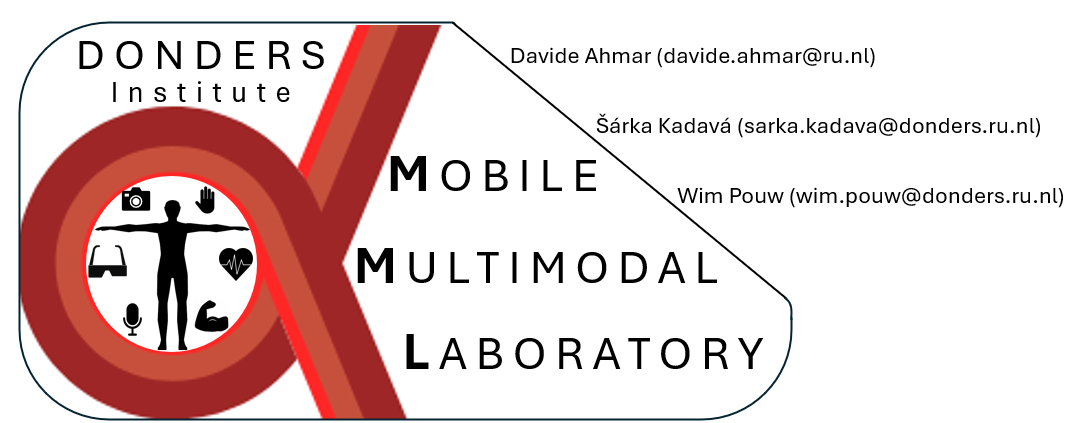

### Info Documents 
Location Repository
Github Repository 
Jupyter Notebook


### Requirements
Please install the necessary packages in requirements.txt using pip install -r requirements.txt


### CODE OVERVIEW
This script is designed to process XDF files, extract data streams, perform renaming and clipping operations, and save the processed data in CSV and WAV formats. The script is structured into several key sections, each performing specific tasks, from importing necessary packages to processing the data and saving the output. Below is a detailed breakdown of each section of the code: 

0. **Packages**
      This section imports all the necessary libraries and modules used throughout the script. These include modules for file handling, data manipulation, audio processing, video processing, plotting, and GUI interaction.
     See requirements.txt for all necessary packages (pip install -r requirements.txt)

1. **Key Variables**
     Users defines the input and output directories for XDF files and result outputs
     - **noise_reducelevel**  Sets the level for noise reduction in audio processing.

    - **extension_to_codec = { ... }**  Maps different file extensions to their corresponding codecs for video processing.
      
    - **rename_dict = { ... }** This dictionary is used to rename certain data streams based on their name and type.
        !! **this dictionary should be adjusted or removed according to the user xdf file**.

1. **Functions**
    - to_audio: Converts time-series data into a WAV audio file.
    - frame_to_time: Converts frame numbers to time format (HH:MM.SS).
    - rename_streams: Renames streams based on the provided dictionary.
    - clip_nonmarker_streams: Clips the start and end of streams based on the shortest stream, excluding marker streams.
    - get_events: Extracts specified events from a marker stream.     

2. **Identifying XDF Files**
   - Method 1. Automatically identifying XDF files in the input directory and its subdirectories by traverses the input directory to find all files with the .xdf extension and adds them to the xdf_files list

    - Method 2.  Manually selecting XDF files using a GUI dialog. Provides an alternative way to manually select XDF files using a graphical file selection dialog.
  
3.  **Identifying XDF Files**

Loading and Renaming Streams: Loads the XDF file and renames streams based on the predefined dictionary.

Clipping Streams: Clips streams to ensure they all start and end at the same time, based on non-marker streams.

Processing Each Stream:

Extracts and formats data from each stream.
Saves the data as CSV files.
Special handling for microphone streams, including saving as WAV files and performing noise reduction.
Subfolder Creation: Automatically creates a subfolder for each XDF file based on its name and saves the processed data inside.
   


## 0. Import all the necessary packages to work with XDF, Audio and Video files 

In [2]:
import os             # Importing the os module which provides functions for interacting with the operating system
import pyxdf          # Importing pyxdf, a Python library for reading XDF files
import glob           # Importing the glob module which helps in finding files/directories with specific patterns
import pandas as pd   # Importing pandas library (abbreviated as pd), which is used for data manipulation and analysis
import numpy as np    # Importing numpy library (abbreviated as np), which is used for numerical computations
import wave           # Importing wave module for reading and writing WAV files (usually audio files) 
import struct         # Importing struct module which provides functions to convert between Python values and C structs
import math           # Importing math module which provides mathematical functions
import random         # Importing random module for generating random numbers
from scipy.io import wavfile  # Importing wavfile module from scipy.io (a library built on numpy), for reading and writing WAV files
import noisereduce as nr      # Importing noisereduce module for noise reduction in audio signals
import json            # Importing json module for working with JSON data
import cv2            # Importing OpenCV library for computer vision tasks
from moviepy.editor import (                # Importing various classes and functions from moviepy.editor module
                            VideoFileClip,  # Class for working with video files
                            AudioFileClip,  # Class for working with audio files
                            CompositeAudioClip)  # Class for composing audio clip
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip  # video  clipping fucntion 
from moviepy.video.io.VideoFileClip import VideoFileClip          # alternative video clipping function
import matplotlib.pyplot as plt                                   # Importing pyplot library to create figures and plot data 
from matplotlib.widgets import Slider  
import tkinter   as tk                                                 # GUI toolkit 
from tkinter import (filedialog, 
                     simpledialog, 
                     Listbox, 
                     StringVar, 
                     messagebox)                         # GUI toolkit 
import subprocess 

print("Everything was imported succesfully") #as terminal

Everything was imported succesfully


## 1. Define the Relevant Paths, Variables & Functions

In [68]:
# ------------ PATHS -----------------------------------------------------
input_folder = './data_raw/'  # input folder with the raw XDF files (relative path) 
output_folder = './data_processed/'  # output folder where the raw extracted data will be saved (relative path) 

print("Input folder =", os.path.abspath(input_folder))
print("Output folder =", os.path.abspath(output_folder))


# ------------ VARIABLES ----------------------------------------------
noise_reducelevel = 1.5  #This can be changed accordingly 


# Dictionary to map file extensions to codecs
extension_to_codec = {
    '.mp4': 'libx264',
    '.avi': 'libxvid',
    '.mov': 'libx264',
    '.mkv': 'libx264',
    '.flv': 'flv',
    # Add more mappings as needed
                    }


# IF NEEDED: Create a dictionary mapping from old stream names to new stream names (# Edit and add more mappings as needed.) 
     # (This dictionary mapping is based both of the stream_names and stream_types because in our case we have 2 streams with the same name (but different types)) 
rename_dict = {
    ('MyWebcamFrameStream_1', 'frameNR'): 'Video_P1',
    ('MyWebcamFrameStream_2', 'frameNR'): 'Video_P2',
    ('Mic', 'voice'): 'Mic_P1',
    ('Mic_004', 'voice'): 'Mic_P2',
    ('OpenSignals', '00:07:80:8C:06:6A'): 'PLUX_P2',
    ('OpenSignals', '00:07:80:D8:A8:81'): 'PLUX_P1'
}


# -------------FUNCTIONS------------------------------------------------------------------------------------
# AUDIO: Creating a function named "to_audio" tht writes audio data (input) and transforms into a WAV file (output). 
def to_audio(fileloc, timeseries_name, timeseries, samplerate =1600, channels = 1):   
    """
    This function - named "to_audio" - writes audio data to a WAV file.
    It accepts the following parameters:
    - fileloc (str): Location to save the audio file.
    - timeserie_name: Name of the timeseries stream to be converted to audio.
    - samplerate (int, optional): Sampling rate of the audio data. Defaults to 16000.
    - channels (int, optional): Number of audio channels (mono or stereo). Defaults to 1 (mono)
    """
    if 'Mic' in timeseries_name:  #Condition check that the timeseriestype belongs to the microphone.
            
        obj = wave.open(fileloc,'w')        # Opens audio file using the wave.open() function write mode ('w'). Assigns data it to the variable obj.
        obj.setnchannels(channels)          # Sets the number of channels in the audio file using obj.setnchannels(channels). Deafault 1 channel (mono).
        obj.setsampwidth(2)                 # Sets the sample width in bytes using obj.setsampwidth(2). The value '2' indicates 16-bit audio.
        obj.setframerate(float(samplerate)) # sets the frame rate of the audio file using obj.setframerate(float(samplerate)), where samplerate is provided as a parameter.
            
        for i in timeseries:                      # Loop to iterate over each time-point in the temeseries stream
            data = struct.pack('<h', int(i[0]))   # Converts the first value of the timeseries to an integer and packs it into a binary string (struck.pack()) according to the '<h' fromat (i.e., short integer (16 bits) in little-endian byte order)   
            obj.writeframesraw( data )            # Writes the packed binary data into an audio file using the wave function writeframesraw() from the wave library 
        obj.close()                               # Closes the audio file 

print("Function \"to_audio\" created sucesfully") 



# Renaming XDF Stream (if necessary)
def rename_streams(streams, rename_dict):
    """
    Function rename_stream renames any streams based on the rename dictionary (if name found in remane_dict)
        Parameters:
    stream_name (str): The current name of the stream.
    stream_type (str): The type of the stream.
    rename_dict (dict): A dictionary mapping old stream names and types to new stream names.
        Returns:
    str: The new stream name if found in rename_dict, otherwise the original stream name.
    """
    for stream in streams:
        stream_name = stream['info']['name'][0]
        stream_type = stream['info']['type'][0]

        if (stream_name, stream_type) in rename_dict:
            new_name = rename_dict[(stream_name, stream_type)]
            print(f'Renaming stream {stream_name} ({stream_type}) to {new_name}')
            stream['info']['name'][0] = new_name  # Rename the stream
    return streams

print("Function \"rename_streams\" created sucesfully") 



                       
# Function to find the START and END times for all streams in XDF file 
def find_start_end_times(streams):  
    """
    Function to find START and END (LSL) times based on user input using a GUI window. 
     The function offers two primary methods for selecting start and end times:
       1. **NOT based on Marker Events**: 
        - Option 1: Automatically selects the latest start time and the earliest end time among all non-marker streams.
        - Option 2: Allows the user to manually input specific start and end times.
        
        2. **Based on Marker Events**:
        - Option 1: Allows the user to specify a single pair of start and end events, using the markers in the data to determine times.
        - Option 2: Allows the user to specify multiple pairs of start and end events, using markers in the data to determine times.

    Input: 
        XDF streams: list of streams to be clipped based on user-selected start and end events or time bounds. Each stream is a dictionary 
                        containing information about the stream, including type, name, time stamps, and time series.
    Output: 
       -  `time_pairs`: A dictionary where the keys are tuples of the form `(start_event, end_event)` (or `(start_marker, end_marker)`), 
      and the values are tuples of the form `(start_time, end_time)`, representing the selected LSL times for extraction.
       -  `method`: A string indicating the method used. It can be one of the following:
                - 'lateststart_earliestend'
                - 'manual_startend'
                - 'marker_ONEpair'
                - 'marker_MULTIPLEpairs'
       
        Notes:
        - Ensure that the streams list contains at least one Marker stream if using the marker-based method.
        - The function relies on `tkinter.simpledialog` for user interaction, so it must be run in an environment that 
          supports GUI windows.
          
        Example Usage:
        start_end_times, method = find_start_end_times(streams)
    """
    
    # Initialize the main application window
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    
    # Ask user for START and END times method with a GUI prompt
    choice = simpledialog.askstring("Clipping Method", 
                                    "Choose the START & END of your streams:\n1. NOT based on Marker Events\n2. Based on Marker Events")
    
    # If the user chooses to select the start and end time NOT based on Marker Events
    if choice == '1':
        choice_1 = simpledialog.askstring("Method NOT based on Marker Event ", 
                                          "Choose one option:\n1. Latest START time (for all streams except Marker) & Earliest END time (for all streams except Marker) \n2. Manual selection of START and END times")
        
        if choice_1 == '1':  # Find the latest start time across all streams except Marker streams
            
            method = 'lateststart_earliestend'
            
            print('Method: ' + method)
            
            # Filter out marker streams for calculating the latest start and earliest end times
            non_marker_streams = [stream for stream in streams if stream['info']['type'][0] != 'Markers']

            for i in non_marker_streams:
                name_i = i['info']['name'][0]
                print(str(name_i))
                
            # Find the latest start time across all non-marker streams
            begintimes = [stream['time_stamps'][0] for stream in non_marker_streams]
            latest_start_time = max(begintimes)  # Get the first timestamp of each non-marker stream and find the maximum (latest start time)
            
            # Find the earliest end time across all non-marker streams
            endtimes = [stream['time_stamps'][-1] for stream in non_marker_streams]
            earliest_end_time = min(endtimes)  # Get the last timestamp of each non-marker stream and find the minimum (earliest end time)
            
            # Create a dictionary with the start and end times stored as tuples
            time_pairs = {('latest_start', 'earliest_end'): (latest_start_time, earliest_end_time)}
            print(f"Selected START & END Time Pairs : {time_pairs}")

        
        elif choice_1 == '2':  # Manual selection of the start and end times
            
            method = 'manual_startend'
            print('Method: ' + method)
            
            # Show the user the Start and end times of all streams 
            for stream in streams:  
                print(f"Stream: {stream['info']['name'][0]}")
                print(f"Start time: {stream['time_stamps'][0]}")
                print(f"End time: {stream['time_stamps'][-1]}")
                
            start_time = simpledialog.askfloat("Manual Selection", 
                                               "Enter the START time in seconds (consider printed start times for all streams for boundaries)")
            end_time = simpledialog.askfloat("Manual Selection", 
                                             "Enter the END time in seconds (consider printed end times for all streams for boundaries)")
            
            # creating a dictionary with the start and end times stored as tuples
            time_pairs = {('manual_start', 'manual_end'): (start_time, end_time)}
            print(f"Selected START & END Time Pairs : {time_pairs}")
            
    elif choice == '2': 
        # Identify a Marker stream 
        marker_stream = [stream for stream in streams if stream['info']['type'][0] == 'Markers'][0]
        
        print("Marker stream: ")
        for i in range(len(marker_stream['time_series'])):
            print(str(marker_stream['time_series'][i]).replace('[', '').replace(']', '').replace("'", ""))   ## Print all the events in the marker stream in an organized way
       
        
        choice_2 = simpledialog.askstring("Method Based on Marker Event ", 
                                          "Choose one option:\n1. Only 1 START & 1 END Events \n2. MULTIPLE START & END Events")
 
        if choice_2 == '1': 
            
            method = 'marker_ONEpair'
            
            print('Method: ' + method)
            
            start_event = simpledialog.askstring("SINGLE PAIR Marker Event", 
                                                 "Enter the START event name (you can copy and paste the event name from the terminal)")
            end_event = simpledialog.askstring("SINGLE PAIR Marker Event", 
                                               "Enter the END event name (you can copy and paste the event name from the terminal)")
            
            print(f"Selected START Event: {start_event}")
            print(f"Selected END Event: {end_event}")
            
            # Find the corresponding LSL times in the Marker stream based on start_event and end_event
            start_time = None
            end_time = None
            for idx, event in enumerate(marker_stream['time_series']):  # enumerate the events (i.e., 'time_series in XDF stream') in the marker stream
                if event[0] == start_event.strip():
                    start_time = marker_stream['time_stamps'][idx]  # Find the corresponding LSL time in the Marker stream based on start_event
                elif event[0] == end_event.strip():
                    end_time = marker_stream['time_stamps'][idx]  # Find the corresponding LSL time in the Marker stream based on end_event
            
            if start_time is None or end_time is None:
                print(f"Could not find both events: {start_event} or {end_event}")
                
            # create a dictionary with the start and end events and the corresponding start and end times stored as tuples
            time_pairs = {(start_event.strip(), end_event.strip()): (start_time, end_time)}   
            print(f"Selected START & END Time Pairs : {time_pairs}")
            
        elif choice_2 == '2':
            
            method = 'marker_MULTIPLEpairs'
            
            print('Method: ' + method)
            
            event_list = simpledialog.askstring("MULTIPLE PAIRS Marker Event",
                                                "Enter each PAIR of START and END events SEQUENTIALLY (you can copy and paste the event name from the terminal). "
                                                "Follow the format exactly: START1:END1, START2:END2, START3:END3, etc.") 
            
            # Convert the event_list into a list of tuples
            if event_list:
                try:
                    # First, split by commas to get each pair, and ensure no extra spaces
                    event_pairs = [pair.split(':') for pair in event_list.replace(" ", "").split(',')]
                    
                    # Ensure that each pair contains exactly two elements (start and end)
                    for pair in event_pairs:
                        if len(pair) != 2:
                            raise ValueError(f"Invalid format for pair: {pair}")
                except Exception as e:
                    print(f"Error in the provided input: {e}")
                    event_pairs = []

                print(f"Selected START & END Event Pairs: {event_pairs}")

            # Find the corresponding LSL times in the Marker stream based on the event_pairs and store them in a dictionary
            time_pairs = {}  # Initialize an empty dictionary to store the time pairs
            for start_event, end_event in event_pairs:  # Iterate over each pair to extract corresponding start and end times
                start_time = None
                end_time = None
                for idx, event in enumerate(marker_stream['time_series']):
                    if event[0] == start_event.strip():
                        start_time = marker_stream['time_stamps'][idx]
                    elif event[0] == end_event.strip():
                        end_time = marker_stream['time_stamps'][idx]

                # If both times are found, add them to the dictionary
                if start_time is not None and end_time is not None:
                   time_pairs[(start_event.strip(), end_event.strip())] = (start_time, end_time)    # Store the events and correspdonding times as a tuple in the dictionary
                else:
                    print(f"Could not find both events: {start_event} or {end_event}")

            print(f"Selected START & END Time Pairs : {time_pairs}")  
                        

    return time_pairs, method


print("Function \"start_end_times\" created sucesfully")




# Function to extract specified events (with correspodning LSL times) from XDF stream (useful for plotting)
def get_events(stream, event_names):
    """
    Extracts events and corresponding LSL times from the given stream that match any of the event_names.

    Parameters:
    stream (dict): The stream containing time stamps and event data.
    event_names (list of str): List of event name substrings to look for in the events.

    Returns:
    np.array: An array where each row contains a timestamp and the full event name.
    """
    events = []  # Initialize an empty list to store matching events

    # Check if the stream type is "Markers"
    if stream['info']['type'][0] != "Markers":
        raise ValueError(f"ERROR: The stream provided ({stream['info']['name'][0]}) is not a Marker stream")

    # Iterate over the time stamps and corresponding events in the stream
    for timestamp, event in zip(stream['time_stamps'], stream['time_series']):
        # Check if any of the specified event names are in the current event
        for name in event_names:
            if name in event[0]:
                # If a match is found, append the timestamp and full event name to the list
                events.append([timestamp, event[0]])

    # Convert the list of events to a NumPy array and return it
    return np.array(events)

print("Function \"get_events\" created sucesfully") 


Input folder = c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_raw
Output folder = c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed
Function "to_audio" created sucesfully
Function "frame_to_time" created sucesfully
Function "rename_streams" created sucesfully
Function "start_end_times" created sucesfully
Function "clip_nonmarker_streams" created successfully
Function "get_events" created sucesfully


## 2. Identifying XDF files in Input Folder or any Subfolder 

In [9]:
xdf_files = []  # Initialize an empty list to store paths of XDF files

# Traverse through the directory and its subdirectories to find XDF files
for root, dirs, files in os.walk(input_folder):  # 1st loop iterating over the results returned by os.walk().
    
    for file in files:                                    # 2nd loop iterating through each file in the current directory
        
        if file.endswith(".xdf"):                         # checking if the file has and XDF extension 
            
             xdf_files.append(os.path.join(root, file))   # if the file is an XDF file, append its full path to the xdf_files list
            
print('We have idenified the following XDF files: ' + str(xdf_files))

We have idenified the following XDF files: ['./data_raw/pilot_ming_02.xdf', './data_raw/T1_experiment.xdf']


## 2a. Alternatively, the user can select their own XDF file

In [4]:
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog # GUI toolkit to open and save files

root = tkinter.Tk()
root.attributes('-topmost',True)
root.iconify()

xdf_files = filedialog.askopenfilename(title="Select an XDF file", filetypes=[("XDF Files", "*.xdf")], multiple = 'True')

root.destroy()

# Convert the tuple returned by askopenfilenames() to a list
xdf_files = list(xdf_files)

print('You have selected the following XDF files: ' + str(xdf_files))

You have selected the following XDF files: ['C:/Users/ahmar/OneDrive/Documents/GitHub/Mobile-Multimodal-Lab/2_PREPROCESSING/1_XDF_PROCESSING/data_raw/T1_experiment.xdf']


# 3. Main Loop that (i) Extracts (ii) Renames and (iii) Clips each data stream from each XDF and saves them as CVS or WAV files 

In [74]:
output_folder = './data_processed/'  # output_folder for the CVS and WAV files 
print("Output folder =", os.path.abspath(output_folder))

for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)

    
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    print('Renaming streams based on the dictionary mapping')
    streams = rename_streams(streams, rename_dict)
    
    #Finding the start and end times for all streams in the XDF file
    print('Finding the start and end times for all streams in the XDF file')
    start_end_times, method = find_start_end_times(streams)  # Call the find_start_end_times function to find the start and end times for all streams in the XDF file.
    
       
    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]
        timevec         = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries      = stream['time_series']                                # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate      = round(float(stream['info']['nominal_srate'][0]))     # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount    = int(stream['info']['channel_count'][0])              # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels
        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate))        


        ## Clipping all streams based on the start and end times
        print('Clipping all streams based on the start and end times')
        
        for (start_event, end_event), (start_time, end_time) in start_end_times.items():
            print(f"Clipping based on event pair: {start_event} - {end_event}")
            print(f"Start time: {start_time}, End time: {end_time}")
            
            # Find the index of the closest timestamp to the start and end times
            start_idx = np.searchsorted(timevec, start_time, side='left')
            end_idx   = np.searchsorted(timevec, end_time, side='right')
            
             # Clip the timevec and timeseries based on the start and end indices
            clipped_timevec = timevec[start_idx:end_idx]
            clipped_timeseries = timeseries[start_idx:end_idx]
            
            # print('start time :'  + str(min(clipped_timevec)))
            # print('end time: '    + str(max(clipped_timevec)))
            
            
            ## SAVING THE CLIPPED DATA AS A CSV FILE
            # Create a csv compatable matrix from the clipped timevec and timeseries (with column names)
            matrix_aux = np.vstack([np.transpose(clipped_timevec), np.transpose(clipped_timeseries)])  # Create matrix_aux by concatenating the transposed clipped_timevec and clipped_timeseries
            matrix = np.transpose(matrix_aux)  # Create new matrix by tranposing matrix_aux
            column_names = ["LSL_Time"] + [f"{timeseries_name}_{label}" for label in channel_labels]
            df_clipped = pd.DataFrame(matrix, columns=column_names)  # Create a DataFrame df_clipped with the combined data and the appropriate column names
            
            # Saving this matrix as a csv file
            subfolder_path = os.path.join(output_folder, fnam.split('_')[0], method)    # Create the subfolder path
            file_name = f'{fnam}_{timeseries_name}_{start_event}_{end_event}'       # Create the file name
            
            os.makedirs(subfolder_path, exist_ok=True)                                  # Create the subfolder if it doesn't exist
            df_clipped.to_csv(os.path.join(subfolder_path, f'{file_name}.csv'), index=False)
            
            print('Saving: ' + fnam + '_' + file_name + " in folder " + subfolder_path) 

            ## CREATING A WAV FILE FOR THE MICROPHONE STREAM
            if "Mic" in timeseries_name:  # Check if the data stream is from a microphone
                subfolder_path_wav = os.path.join(subfolder_path, f'{file_name}.wav')   # Define the location to save the initial audio file
                 # Normalize the file path to avoid mixed path separators
                subfolder_path_wav = os.path.normpath(subfolder_path_wav)
                to_audio(subfolder_path_wav, timeseries_name, clipped_timeseries)        # Convert the time series data to an audio file and save it at the defined location
                rate, data = wavfile.read(subfolder_path_wav)                           # Load the audio data from the saved WAV file
                reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=noise_reducelevel, stationary=True)    # Perform noise reduction based on the noise_reducelevel 
                
                subfolder_path_wav_2 = os.path.join(subfolder_path, f'{file_name}_denoised.wav')
                 # Normalize the path for the denoised file
                subfolder_path_wav_2 = os.path.normpath(subfolder_path_wav_2)
               
                wavfile.write(subfolder_path_wav_2, rate, reduced_noise)                                                        # Save the noise-reduced audio data as a new WAV file at the defined location

print("Done with extracting all the streams! You can now look into your folder: " + output_folder)

Output folder = c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed
loading xdf file: C:/Users/ahmar/OneDrive/Documents/GitHub/Mobile-Multimodal-Lab/2_PREPROCESSING/1_XDF_PROCESSING/data_raw/T1_experiment.xdf
Renaming streams based on the dictionary mapping
Renaming stream MyWebcamFrameStream_2 (frameNR) to Video_P2
Renaming stream MyWebcamFrameStream_1 (frameNR) to Video_P1
Renaming stream OpenSignals (00:07:80:8C:06:6A) to PLUX_P2
Renaming stream OpenSignals (00:07:80:D8:A8:81) to PLUX_P1
Renaming stream Mic (voice) to Mic_P1
Renaming stream Mic_004 (voice) to Mic_P2
Finding the start and end times for all streams in the XDF file
Marker stream: 
NoVision_NoMovement_0_StartTrial
NoVision_NoMovement_0_StartAudioPresentation
NoVision_NoMovement_0_StartAudioPresentation
NoVision_NoMovement_0_StartParticipantSinging
NoVision_NoMovement_0_EndParticipantSinging
NoVision_NoMovement_1_StartTrial
NoVision_NoMovement_1_StartAudioPresent

## 4. Plotting Each XDF and Each Stream (Quality Check)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


# Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.)
for stream in streams:  # Iterate over each steam in the loaded steam for each XDF file.
    timeseries_name = stream['info']['name'][0]  # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic).
    timeseries_type = stream['info']['type'][0]  # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers).
    timevec = stream['time_stamps']  # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
    timeseries = stream['time_series']  # Extract the time_series (i.e., DATA) from the "stream" dictionary and
    samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assigns it to samplerate
    channelcount = int(stream['info']['channel_count'][0])  # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

    # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
    channel_labels = []  # Initialize an empty list to store channel labels
    # Check if there is more than one channel and if the 'desc' field is present in the stream's info
    if channelcount > 1 and stream['info']['desc'] is not None:
        try:
            channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
            channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
        except (KeyError, IndexError):
            channel_labels = [f"Channel {i + 1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
    else:
        channel_labels = [f"Channel {i + 1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

    print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate))

    # Extracting Relevant Events from Marker Stream that will be used as Selectors in the Plots
    if timeseries_type == 'Markers':
        audio_events = get_events(stream, event_names)  # Using the get_events function to extract events and corresponding LSL times from Marker stream

        # Create selector buttons based on audio events
        selector_buttons = []
        for i in range(0, len(audio_events), 2):
            start_event = audio_events[i]
            end_event = audio_events[i + 1]
            condition_name = start_event[1].split('_StartParticipantSinging')[0]
            selector_buttons.append(dict(label=condition_name,
                                         method="relayout",
                                         args=[{"xaxis.range": [float(start_event[0]), float(end_event[0])]}]))

        continue  # Skips plotting for Markers stream

    # PLOTTING
    timeseries = np.array(timeseries)  # Ensure timeseries is a NumPy array

    # Plotting subplots in case of multiple channels
    if channelcount > 1:
        fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)

        for i in range(channelcount):
            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, i],
                mode='lines',
                name=channel_labels[i]
            ), row=i + 1, col=1)

        # Update x-axis settings for the last subplot
        fig.update_xaxes(
            rangeslider=dict(visible=True),
            type="linear",
            row=channelcount, col=1
        )
        
        fig.update_layout(
            title_text=fnam + '_' + timeseries_name + ' Streams',
            height=150 * channelcount + 150,
            yaxis_title='Amplitude',
            updatemenus=[dict(type="buttons", buttons=selector_buttons, direction="down", showactive=True)]
        )
        fig.show()

    else:
        # Plotting single channel data stream
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=timevec,
            y=timeseries[:, 0],
            mode='lines',
            name=channel_labels[0]
        ))

        fig.update_layout(
            title_text=fnam + '_' + timeseries_name + ' Streams',
            xaxis=dict(
                rangeselector=dict(buttons=selector_buttons),
                rangeslider=dict(visible=True),
                type="linear"
            ),
            yaxis_title='Amplitude',
            updatemenus=[dict(type="buttons", buttons=selector_buttons, direction="down", showactive=True)]
        )

        fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
       
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    streams = rename_streams(streams, rename_dict)

    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]                     # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers). 
        timevec = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries = stream['time_series']                             # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount = int(stream['info']['channel_count'][0])         # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate)) 
        
        
        
        # Extracting Relevant Events from Marker Steam that will be used as Selectors in the Plots 
        if timeseries_type == 'Markers':
            audio_events = get_events(stream, event_names)  #Using the get_events function to extracts events and corresponding LSL times from Marker stream

             # Create selector buttons based on audio events
            selector_buttons = []
            for i in range(0, len(audio_events), 2):
                start_event = audio_events[i]
                end_event = audio_events[i + 1]
                condition_name = start_event[1].split('_StartParticipantSinging')[0]
                selector_buttons.append(dict(label=condition_name,
                                             method="relayout",
                                             args=[{"xaxis.range": [float(start_event[0]), float(end_event[0])]}]))
                        
            continue    # Skips plotting for Markers stream 
            
        # PLOTTING 
        timeseries = np.array(timeseries)   # Ensure timeseries is a NumPy array
        
         # Plotting subplots in case of multiple channels
        if channelcount > 1:
            fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)
        
            for i in range(channelcount):
                fig.add_trace(go.Scatter(
                    x=timevec, 
                    y=timeseries[:, i],
                    mode='lines',
                    name=channel_labels[i]
                ), row=i+1, col=1)
        
            # Update x-axis settings for the last subplot
            fig.update_xaxes(
                rangeslider=dict(visible=True),
                type="linear",
                row=channelcount, col=1
            )

            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                height=150 * channelcount + 150,
                yaxis_title='Amplitude',
                updatemenus=[dict(buttons=selector_buttons, direction="down", showactive=True)]
            )

            fig.show()
            
        else:
            # Plotting single channel data stream
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, 0],
                mode='lines',
                name=channel_labels[0]
            ))

            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                xaxis=dict(
                    rangeselector=dict(buttons=selector_buttons),
                    rangeslider=dict(visible=True),
                    type="linear"
                ),
                yaxis_title='Amplitude',
                updatemenus=[dict(buttons=selector_buttons, direction="down", showactive=True)]
            )

            fig.show()

In [ ]:
print(selector_buttons)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
       
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    streams = rename_streams(streams, rename_dict)

    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]                     # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers). 
        timevec = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries = stream['time_series']                             # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount = int(stream['info']['channel_count'][0])         # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate)) 
        
        
        
        # Extracting Relevant Events from Marker Steam that will be used as Selectors in the Plots 
        if timeseries_type == 'Markers':
            audio_events_steam = get_events(stream, event_names)  #Using the get_events function to extracts events and corresponding LSL times from Marker stream

            continue    # Skips plotting for Markers stream 
            
        # PLOTTING 
        timeseries = np.array(timeseries)   # Ensure timeseries is a NumPy array
        
        # Plotting subplots in case of multiple streams 
        if channelcount > 1:
            fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)
        
            for i in range(channelcount):
                fig.add_trace(go.Scatter(
                    x=timevec, 
                    y=timeseries[:, i],
                    mode='lines',
                    name=channel_labels[i]
                ), row=i+1, col=1)
        
                fig.update_yaxes(title_text=channel_labels[i], row=i+1, col=1)
        
            # Update x-axis settings for all subplots
            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                height=300 * channelcount,
                xaxis=dict(
                    rangeselector=dict(
                        buttons=list([
                            dict(count=1,
                                 label="1m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(count=10,
                                 label="10m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(step="all")
                        ])
                    ),
                    rangeslider=dict(
                        visible=True
                    ),
                    type="linear"
                ),
                yaxis_title='Amplitude'
            )
        
            fig.show()
                    
        else:
            # Plotting single channel data stream
            fig = go.Figure()
            timeseries = np.array(timeseries)  # Ensure timeseries is a NumPy array
        
            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, 0],
                mode='lines',
                name=channel_labels[0]
            ))
        
            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                xaxis=dict(
                    rangeselector=dict(
                        buttons=list([
                            dict(count=1,
                                 label="1m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(count=10,
                                 label="10m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(step="all")
                        ])
                    ),
                    rangeslider=dict(
                        visible=True
                    ),
                    type="linear"
                ),
                yaxis_title='Amplitude'
            )
        
            fig.show()

                

In [ ]:
                     # fig.show()
        
            #     # Update x-axis settings for the last subplot
            #     if i == channelcount-1:
            #         fig.update_xaxes(
            #             rangeselector=dict(
            #                 buttons=list([
            #                     dict(count=1,
            #                          label="1m",
            #                          step="minute",
            #                          stepmode="backward"),
            #                     dict(count=10,
            #                          label="10m",
            #                          step="minute",
            #                          stepmode="backward"),
            #                     dict(step="all")
            #                 ])
            #             ),
            #             rangeslider=dict(
            #                 visible=True
            #             ),
            #             type="linear",
            #             row=i+1, col=1
                        )

            # Plotting Events (i.e., triggers) 
        # if stream['info']['channel_format'][0] == 'string':
        #     plt.figure(figsize=(12, 6))
        #     y_pos = np.arange(len(timevec))  # Create a y-position for each event to avoid overlap
        #     plt.scatter(timevec, [1] * len(timevec), marker='o')
        #     for i, event in enumerate(timeseries):
        #         plt.text(timevec[i], 1.01, event[0], rotation=45, ha='right', va='bottom', fontsize=6)
        #     plt.title(fnam + '_' + timeseries_type + ' Events')
        #     plt.xlabel('Time')
        #     plt.yticks([])
        #     plt.grid(True)
        #     plt.show()


        #     else:
        #     # Plotting data streams with Plotly subplots if multiple channels
        



            
            # # Plotting data streams with subplots and sliders
            # fig, axs = plt.subplots(channelcount, 1, figsize=(12, 6 * channelcount), sharex=True)
            # timeseries = np.array(timeseries)
            # if channelcount == 1:
            #     axs = [axs]  # Ensure axs is always a list

            # for i in range(channelcount):
            #     axs[i].plot(timevec, timeseries[:, i], label=channel_labels[i])
            #     axs[i].set_title(f'{channel_labels[i]}')
            #     axs[i].set_ylabel('Amplitude')
            #     axs[i].grid(True)
            #     axs[i].legend()

            # axs[-1].set_xlabel('Time')

            # # Adding slider for each subplot
            # sliders = []
            # axcolor = 'lightgoldenrodyellow'
            # for i in range(channelcount):
            #     ax_slider = plt.axes([0.25, 0.02 + i * 0.04, 0.65, 0.03], facecolor=axcolor)
            #     slider = Slider(ax_slider, 'Range', timevec[0], timevec[-1], valinit=timevec[-1])
            #     sliders.append(slider)

            #     def update(val, ax=axs[i], slider=slider):
            #         pos = slider.val
            #         ax.set_xlim(timevec[0], pos)
            #         fig.canvas.draw_idle()

            #     slider.on_changed(update)

            # plt.tight_layout()
            # plt.show()
             
        # else:
        #         # Plotting data streams 
        #     plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
        #     timeseries = np.array(timeseries)
        #     for i in range(channelcount):
        #         plt.plot(timevec, timeseries[:, i], label=channel_labels[i])
        #     plt.title(fnam + '_' + timeseries_type + ' Streams')
        #     plt.xlabel('Time')
        #     plt.ylabel('Amplitude')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()
        ## -------------------------------------------------